# mRMR 饱和曲线分析
# 目标：确定每个组学应该筛选多少特征

----------------------------------------------Reading data----------------------------------------------
             Subtype
PatientID           
TCGA-EW-A2FS    LumA
Index(['TCGA-EW-A2FS', 'TCGA-OL-A6VR', 'TCGA-E9-A226', 'TCGA-D8-A27H',
       'TCGA-D8-A3Z6', 'TCGA-B6-A1KN', 'TCGA-BH-A2L8', 'TCGA-A8-A075',
       'TCGA-JL-A3YX', 'TCGA-D8-A3Z5',
       ...
       'TCGA-D8-A1XO', 'TCGA-C8-A8HQ', 'TCGA-BH-A42T', 'TCGA-GM-A2D9',
       'TCGA-BH-A0H3', 'TCGA-LL-A5YP', 'TCGA-V7-A7HQ', 'TCGA-GM-A3XL',
       'TCGA-AO-A03L', 'TCGA-E2-A1IU'],
      dtype='object', name='PatientID', length=702)
The number of samples: 702
mRNA: 3000 Features
miRNA: 800 Features
Methylation: 2000 Features
CNV: 2000 Features
----------------------------------------------Preprocessing----------------------------------------------
----------------------------------------------Analyzing mRNA----------------------------------------------
Step 1/2: mRMR selects 400 features...


100%|██████████| 400/400 [01:29<00:00,  4.46it/s]


Step 2/2: computing perform for different number of features ...


Processing mRNA: 100%|██████████| 20/20 [04:34<00:00, 13.74s/step]


----------------------------------------------Analyzing miRNA----------------------------------------------
Step 1/2: mRMR selects 200 features...


100%|██████████| 200/200 [00:28<00:00,  6.92it/s]


Step 2/2: computing perform for different number of features ...


Processing miRNA: 100%|██████████| 20/20 [02:25<00:00,  7.30s/step]


----------------------------------------------Analyzing Methylation----------------------------------------------
Step 1/2: mRMR selects 400 features...


100%|██████████| 400/400 [01:44<00:00,  3.84it/s]


Step 2/2: computing perform for different number of features ...


Processing Methylation: 100%|██████████| 20/20 [05:10<00:00, 15.51s/step]


----------------------------------------------Analyzing CNV----------------------------------------------
Step 1/2: mRMR selects 400 features...


100%|██████████| 400/400 [01:43<00:00,  3.85it/s]


Step 2/2: computing perform for different number of features ...


Processing CNV: 100%|██████████| 20/20 [01:12<00:00,  3.61s/step]


----------------------------------------------Figuring----------------------------------------------


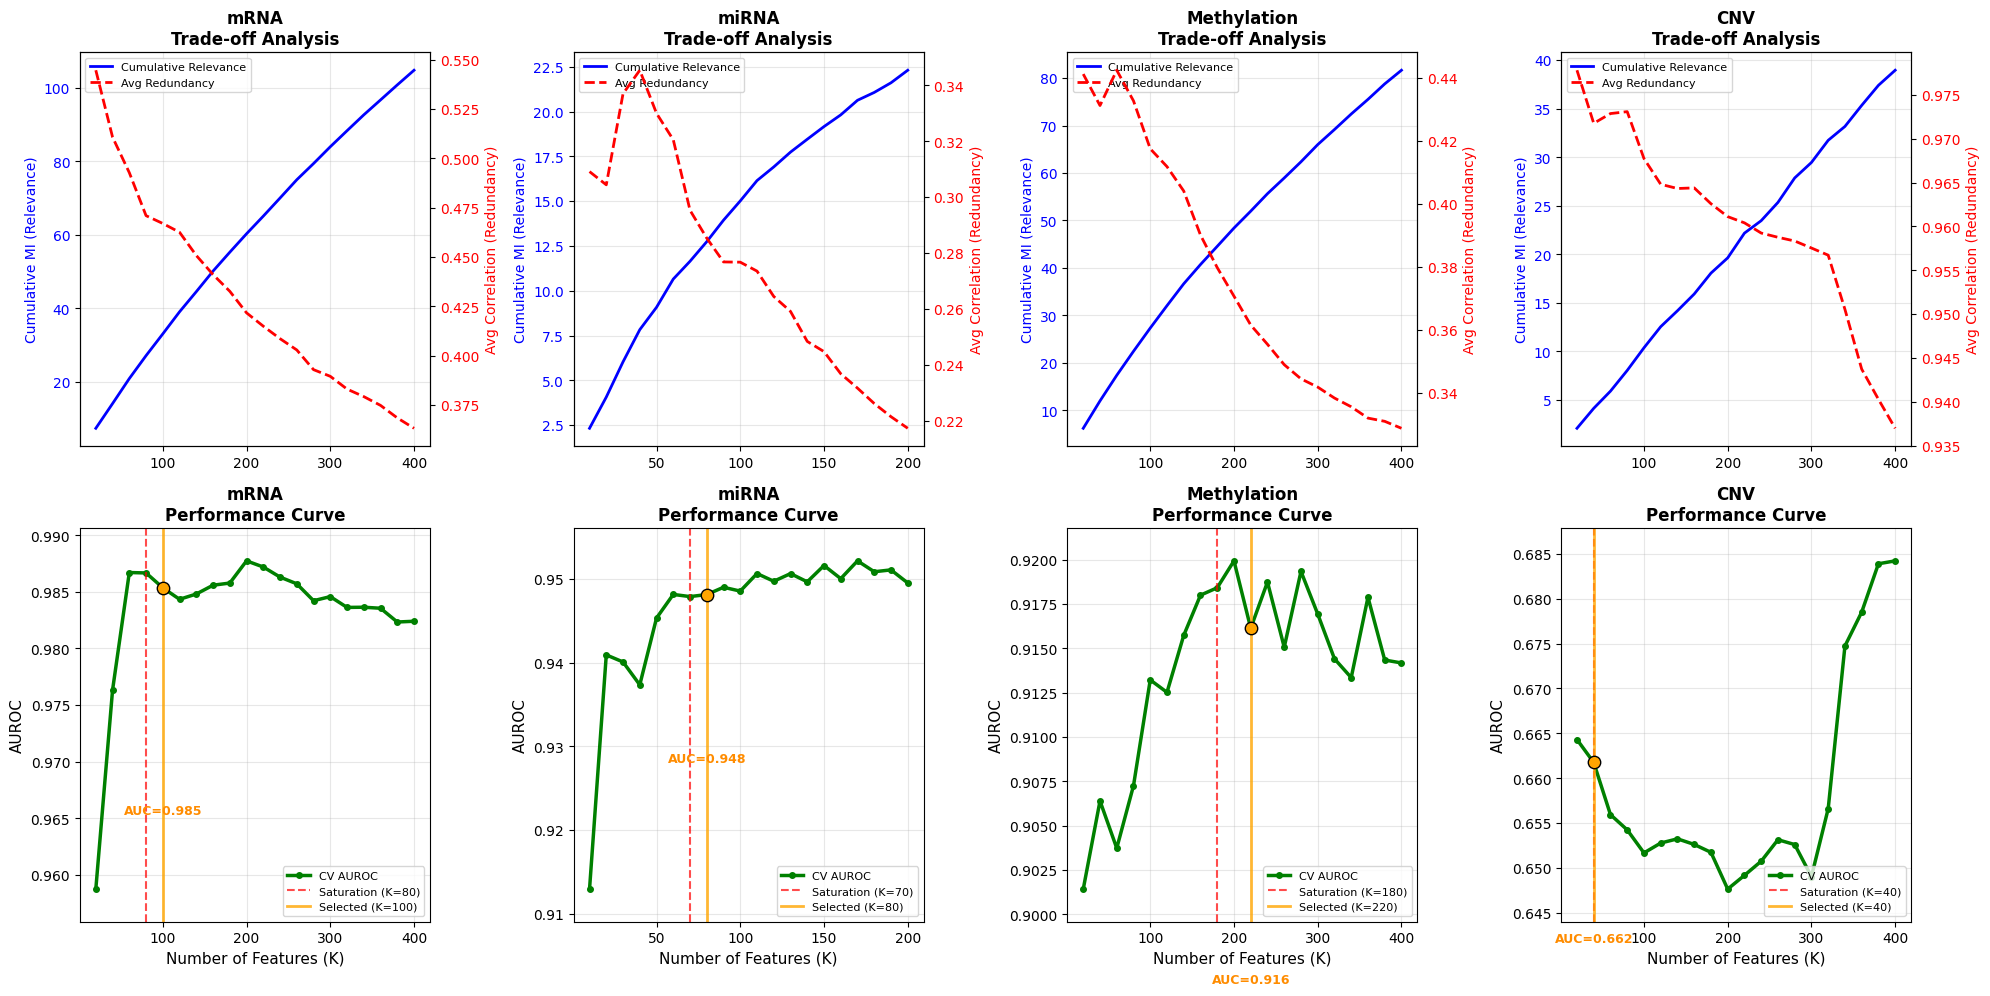

Omics        point      recommended AUC          maxAUC       loss      
----------------------------------------------------------------------

Omics Type      | Saturation K | Selected K   | Selected AUC | Max Potential AUC  | Loss
-------------------------------------------------------------------------------------
mRNA            | 80           | 100          | 0.9854       | 0.9877            | -0.0024
miRNA           | 70           | 80           | 0.9481       | 0.9521            | -0.0040
Methylation     | 180          | 220          | 0.9161       | 0.9199            | -0.0038
CNV             | 40           | 40           | 0.6618       | 0.6842            | -0.0224



In [23]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import mutual_info_regression
from tqdm import tqdm
from mrmr import mrmr_classif
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

print('----------------------------------------------Reading data----------------------------------------------')
labels = pd.read_csv('../PSN_Output/Patient_Labels.csv', index_col = 0)
print(labels.head(1))
y = labels['Subtype']
y = y[y.isin(['LumA','LumB','Her2','Basal'])]
samples = y.index
print(samples)

mrna = pd.read_csv("../PSN_Output/Features_mRNA.csv", index_col = 0).loc[samples]        # 3000
mirna = pd.read_csv("../PSN_Output/Features_miRNA.csv", index_col = 0).loc[samples]      # 800
meth = pd.read_csv("../PSN_Output/Features_Methylation.csv", index_col = 0).loc[samples] # 2000
cnv = pd.read_csv("../PSN_Output/Features_CNV.csv", index_col = 0).loc[samples]          # 2000

print(f"The number of samples: {len(samples)}")
print(f"mRNA: {mrna.shape[1]} Features")
print(f"miRNA: {mirna.shape[1]} Features")
print(f"Methylation: {meth.shape[1]} Features")
print(f"CNV: {cnv.shape[1]} Features")

print('----------------------------------------------Preprocessing----------------------------------------------')
def preprocess_omics(df):
    scaler = StandardScaler()
    return pd.DataFrame(scaler.fit_transform(df), index=df.index, columns=df.columns)

mrna_s = preprocess_omics(mrna)
mirna_s = preprocess_omics(mirna)
meth_s = preprocess_omics(meth)
cnv_s = preprocess_omics(cnv)

def analyze_saturation(omics_df, omics_name, y_labels, max_k = 500, step = 20):
    """
    Analyze the saturation curve of feature selection
    """
    y_arr = y_labels.values
    ks = list(range(step, max_k + 1, step))
    
    cumulative_relevance = []
    avg_redundancy = []
    auc_scores = []

    print(f'----------------------------------------------Analyzing {omics_name}----------------------------------------------')
    print(f"Step 1/2: mRMR selects {max_k} features...")
    
    selected_features_ranked = mrmr_classif(X = omics_df, y = y_labels, K = max_k)

    
    print(f"Step 2/2: computing perform for different number of features ...")
    for k in tqdm(ks, desc = f"Processing {omics_name}", unit = "step"):
        
        selected_names = selected_features_ranked[:k]
        X_sel = omics_df.loc[:, selected_names]
            

        mi_with_label = mutual_info_classif(X_sel, y_arr, random_state = 42, n_neighbors = 3)
        cumulative_relevance.append(mi_with_label.sum())
            

        if k > 1:
            corr_matrix = X_sel.corr().abs()
            redundancy = (corr_matrix.sum().sum() - k) / (k * (k - 1))
        else:
            redundancy = 0
        avg_redundancy.append(redundancy)
            

        clf = GradientBoostingClassifier(
                n_estimators = 50, 
                random_state = 42, 
                max_depth = 3, 
                learning_rate = 0.1
            )
        scores = cross_val_score(
                clf, X_sel, y_arr, 
                cv = 3, 
                scoring='roc_auc_ovr_weighted', 
                n_jobs = -1
            )
        auc_scores.append(scores.mean())
    return ks, cumulative_relevance, avg_redundancy, auc_scores

def find_saturation_point(ks, auc_scores, window = 3, threshold = 0.002):
    """
    find_saturation_point
    """
    if len(auc_scores) < window + 1:
        return ks[-1]
    
    auc_diff = np.diff(auc_scores)
    for i in range(len(auc_diff) - window + 1):
        if all(auc_diff[i:i+window] < threshold):

            return ks[i+1]

    return ks[-1]


results = {}
omics_data = [
    ("mRNA", mrna_s, 400, 20),
    ("miRNA", mirna_s, 200, 10),
    ("Methylation", meth_s, 400, 20),
    ("CNV", cnv_s, 400, 20)
]

for name, df, maxk, step in omics_data:
    result = analyze_saturation(df, name, y, max_k = maxk, step = step)
    if result[0] is not None: 
        results[name] = result

print('----------------------------------------------Figuring----------------------------------------------')
fig = plt.figure(figsize=(20, 10)) 
recommendations = {}

for i, name in enumerate(['mRNA', 'miRNA', 'Methylation', 'CNV'], 1):
    if name not in results:
        continue
        
    ks, rel, red, auc = results[name]
    

    plt.subplot(2, 4, i)
    ax1 = plt.gca()

    line1 = ax1.plot(ks, rel, 'b-', linewidth=2, label='Cumulative Relevance')
    ax1.set_ylabel('Cumulative MI (Relevance)', color='b', fontsize=10)
    ax1.tick_params(axis='y', labelcolor='b')
    ax1.grid(True, alpha=0.3)
    
    ax2 = ax1.twinx()

    line2 = ax2.plot(ks, red, 'r--', linewidth=2, label='Avg Redundancy')
    ax2.set_ylabel('Avg Correlation (Redundancy)', color='r', fontsize=10)
    ax2.tick_params(axis='y', labelcolor='r')
    
    plt.title(f'{name}\nTrade-off Analysis', fontsize=12, fontweight='bold')
    

    lines = line1 + line2
    labels_list = [l.get_label() for l in lines]
    ax1.legend(lines, labels_list, loc='upper left', fontsize=8)
    

    plt.subplot(2, 4, i+4)
    plt.plot(ks, auc, 'g-', linewidth=2.5, label='CV AUROC', marker='o', markersize=4)
    plt.xlabel('Number of Features (K)', fontsize=11)
    plt.ylabel('AUROC', fontsize=11)
    plt.grid(True, alpha=0.3)
    

    sat_k = find_saturation_point(ks, auc, window=3, threshold=0.002)
    

    recommend_k = int(sat_k * 1.2)
    

    if recommend_k > max(ks):
        recommend_k = max(ks)
    recommend_k = min(ks, key=lambda x:abs(x-recommend_k))
    

    sat_idx = ks.index(sat_k)
    sat_auc = auc[sat_idx]
    
    rec_idx = ks.index(recommend_k)
    rec_auc = auc[rec_idx]

    recommendations[name] = {
        'saturation': sat_k,
        'recommended': recommend_k,
        'max_auc': max(auc),
        'auc_at_rec': rec_auc
    }
    
    plt.axvline(sat_k, color='red', linestyle='--', linewidth=1.5, 
                alpha=0.7, label=f'Saturation (K={sat_k})')
    plt.axvline(recommend_k, color='orange', linestyle='-', linewidth=2, 
                alpha=0.8, label=f'Selected (K={recommend_k})')
            
    plt.scatter([recommend_k], [rec_auc], color='orange', s=80, zorder=5, edgecolors='black')
    plt.text(recommend_k, rec_auc - 0.02, f'AUC={rec_auc:.3f}', 
             ha='center', fontsize=9, color='darkorange', weight='bold')
    
    plt.title(f'{name}\nPerformance Curve', fontsize=12, fontweight='bold')
    plt.legend(loc='lower right', fontsize=8)
            
    auc_min, auc_max = min(auc), max(auc)
    auc_range = auc_max - auc_min
    if auc_range > 0:
        plt.ylim([auc_min - 0.1*auc_range, auc_max + 0.1*auc_range])

plt.tight_layout()
plt.savefig("MultiOmics_Feature_Selection.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"{'Omics':<12} {'point':<10} {'recommended':<10} {'AUC':<12} {'maxAUC':<12} {'loss':<10}")
print("-"*70)

print("\n" + "="*85)
print(f"{'Omics Type':<15} | {'Saturation K':<12} | {'Selected K':<12} | {'Selected AUC':<12} | {'Max Potential AUC':<18} | {'Loss'}")
print("-" * 85)

for name in ['mRNA', 'miRNA', 'Methylation', 'CNV']:
    if name not in recommendations:
        continue
    rec = recommendations[name]

    relative_loss = (rec['max_auc'] - rec['auc_at_rec'])
    
    print(f"{name:<15} | {rec['saturation']:<12} | {rec['recommended']:<12} | "
          f"{rec['auc_at_rec']:.4f}       | {rec['max_auc']:.4f}            | -{relative_loss:.4f}")
print("="*85 + "\n")



#  features filter
'mRNA': 100,  
'miRNA': 80,  
'Methylation': 220,  
'CNV': 40  

In [24]:
import pandas as pd
from mrmr import mrmr_classif
from tqdm import tqdm

final_k_selection = {
    'mRNA': 100,
    'miRNA': 80,
    'Methylation': 220,
    'CNV': 40
}

omics_map = {
    'mRNA': mrna_s,
    'miRNA': mirna_s,
    'Methylation': meth_s,
    'CNV': cnv_s
}

selected_features_dict = {}
subset_dataframes = []

print(f"{'Omics':<15} | {'Target K':<10} | {'Status'}")
print("-" * 45)


for name, k in final_k_selection.items():
    df = omics_map[name]
    

    selected_feats = mrmr_classif(X = df, y = y, K = k, show_progress=False)
    selected_features_dict[name] = selected_feats
    
    df_subset = df[selected_feats].copy()
    df_subset.columns = [f"{name}_{col}" for col in df_subset.columns]
    
    subset_dataframes.append(df_subset)
    
    print(f"{name:<15} | {k:<10} | ✅ Selected")

X_multiomics = pd.concat(subset_dataframes, axis=1)

print("-" * 45)
print(f"the shape of feature matrix : {X_multiomics.shape}")

X_multiomics.to_csv("MultiOmics_Selected_Features_Matrix.csv")


with open("Selected_Features_List.txt", "w") as f:
    for name, feats in selected_features_dict.items():
        f.write(f"[{name}] - {len(feats)} features:\n")
        f.write(",".join(feats) + "\n\n")


Omics           | Target K   | Status
---------------------------------------------
mRNA            | 100        | ✅ Selected
miRNA           | 80         | ✅ Selected
Methylation     | 220        | ✅ Selected
CNV             | 40         | ✅ Selected
---------------------------------------------
the shape of feature matrix : (702, 440)


# Final 100 Features


In [27]:
X_multiomics = pd.read_csv("Multiomics_Selected_Features_Matrix.csv", index_col=0)

y = labels.loc[X_multiomics.index, 'Subtype']
y = y[y.isin(['LumA','LumB','Her2','Basal'])]

final_100_features = mrmr_classif(X = X_multiomics, y = y, K = 100)

pd.Series(final_100_features).to_csv("Final_100_CrossOmics_Anchors.txt", index = False, header = ['Feature_Name'])
print(final_100_features)

100%|██████████| 100/100 [00:07<00:00, 13.09it/s]

['mRNA_ENSG00000115648.14', 'mRNA_ENSG00000172478.18', 'mRNA_ENSG00000179862.7', 'mRNA_ENSG00000091831.24', 'mRNA_ENSG00000124664.11', 'mRNA_ENSG00000173467.9', 'mRNA_ENSG00000054598.9', 'mRNA_ENSG00000107485.18', 'mRNA_ENSG00000106541.12', 'mRNA_ENSG00000100219.16', 'mRNA_ENSG00000176532.4', 'miRNA_V233', 'mRNA_ENSG00000204385.13', 'mRNA_ENSG00000074410.14', 'mRNA_ENSG00000143476.18', 'mRNA_ENSG00000134830.6', 'mRNA_ENSG00000109436.8', 'mRNA_ENSG00000169083.18', 'mRNA_ENSG00000120262.10', 'mRNA_ENSG00000168350.8', 'mRNA_ENSG00000160180.15', 'mRNA_ENSG00000163879.11', 'mRNA_ENSG00000248360.7', 'miRNA_V422', 'mRNA_ENSG00000187720.14', 'mRNA_ENSG00000198729.5', 'mRNA_ENSG00000115163.15', 'mRNA_ENSG00000092068.20', 'miRNA_V439', 'mRNA_ENSG00000165140.11', 'mRNA_ENSG00000178935.5', 'mRNA_ENSG00000135069.14', 'mRNA_ENSG00000139865.16', 'mRNA_ENSG00000187486.5', 'mRNA_ENSG00000163064.7', 'mRNA_ENSG00000076382.17', 'mRNA_ENSG00000102243.13', 'mRNA_ENSG00000137975.8', 'miRNA_V85', 'mRNA_ENSG00

Start Global Selection on 440 features...
Running RFECV...
Optimal number of features: 85


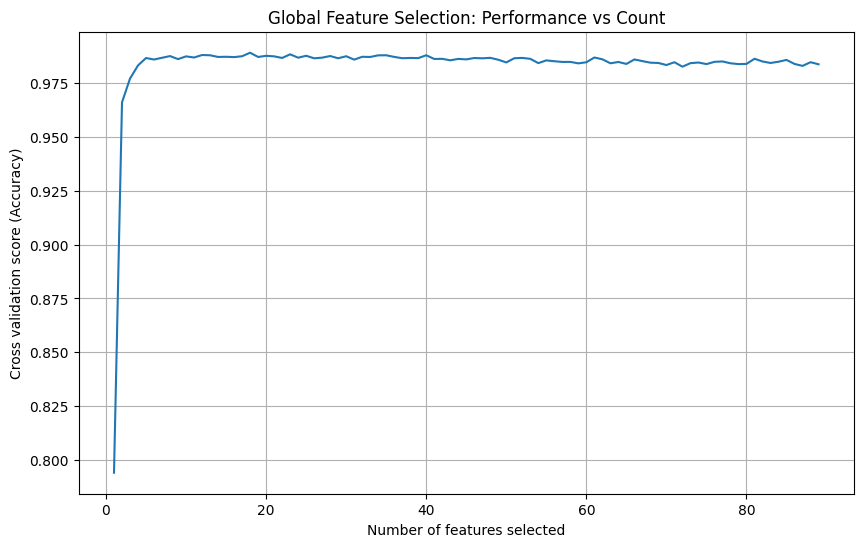


======== 最终入选的黄金特征 (The Global Signature) ========
Total: 85
['mRNA_ENSG00000115648.14', 'mRNA_ENSG00000091831.24', 'mRNA_ENSG00000124664.11', 'mRNA_ENSG00000173467.9', 'mRNA_ENSG00000054598.9', 'mRNA_ENSG00000107485.18', 'mRNA_ENSG00000100219.16', 'mRNA_ENSG00000176532.4', 'mRNA_ENSG00000074410.14', 'mRNA_ENSG00000143476.18', 'mRNA_ENSG00000134830.6', 'mRNA_ENSG00000109436.8', 'mRNA_ENSG00000169083.18', 'mRNA_ENSG00000120262.10', 'mRNA_ENSG00000160180.15', 'mRNA_ENSG00000248360.7', 'mRNA_ENSG00000137975.8', 'mRNA_ENSG00000198729.5', 'mRNA_ENSG00000187720.14', 'mRNA_ENSG00000076382.17', 'mRNA_ENSG00000115163.15', 'mRNA_ENSG00000139865.16', 'mRNA_ENSG00000182175.14', 'mRNA_ENSG00000094755.17', 'mRNA_ENSG00000186832.9', 'mRNA_ENSG00000087586.18', 'mRNA_ENSG00000225362.10', 'mRNA_ENSG00000065328.17', 'mRNA_ENSG00000186868.16', 'mRNA_ENSG00000080986.13', 'mRNA_ENSG00000115255.12', 'mRNA_ENSG00000287914.1', 'mRNA_ENSG00000154839.10', 'mRNA_ENSG00000188959.9', 'mRNA_ENSG00000196208.14', 'mR

In [28]:
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder

print(f"Start Global Selection on {X_multiomics.shape[1]} features...")

# 1. 准备数据
# 确保 y 是数字编码 (0, 1, 2, 3) 而不是字符串
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# 2. 定义裁判模型 (使用随机森林，因为它抗噪能力强，适合多组学)
clf = RandomForestClassifier(n_estimators = 100, random_state = 42, n_jobs = -1)

# 3. 设置“末位淘汰”机制 (RFECV)
# step=5: 每轮淘汰 5 个最弱的特征
# cv=5: 5折交叉验证，保证客观
rfecv = RFECV(
    estimator = clf, 
    step = 5, 
    cv = StratifiedKFold(5), 
    scoring = 'roc_auc_ovr_weighted', 
    n_jobs=-1
)

# 4. 开始训练 (可能需要几分钟)
print("Running RFECV...")
rfecv.fit(X_multiomics, y_encoded)

# ==========================================
# 5. 结果可视化
# ==========================================
print(f"Optimal number of features: {rfecv.n_features_}")

plt.figure(figsize=(10, 6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (Accuracy)")

# 画出得分曲线
# rfecv.cv_results_['mean_test_score'] 存的是每次迭代的分数
# 我们需要把 x 轴换算成特征数量
n_features_steps = [
    range(1, len(rfecv.cv_results_['mean_test_score']) + 1)
] 
# 注：sklearn 新版本中可以直接画，旧版本需要自己构造x轴，
# 这里直接画简单的：
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'])
plt.title("Global Feature Selection: Performance vs Count")
plt.grid(True)
plt.show()

# ==========================================
# 6. 提取并保存“总决赛”名单
# ==========================================
# 获取最终保留的特征掩码
mask = rfecv.support_

# 选出特征名
final_global_features = X_multiomics.columns[mask]

print("\n======== 最终入选的黄金特征 (The Global Signature) ========")
print(f"Total: {len(final_global_features)}")
print(list(final_global_features))

# 保存最终矩阵
X_final = X_multiomics[final_global_features]
X_final.to_csv("Final_Omics_Signature_Matrix.csv")

# 保存名单
with open("Final_Signature_List.txt", "w") as f:
    f.write("\n".join(final_global_features))

# TOP 65

In [3]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from mrmr import mrmr_classif
import sys

print('----------------------------------------------Reading data----------------------------------------------')
labels = pd.read_csv('../PSN_Output/Patient_Labels.csv', index_col = 0)
print(labels.head(1))
y = labels['Subtype']
y = y[y.isin(['LumA','LumB','Her2','Basal'])]
samples = y.index
print(samples)

mrna = pd.read_csv("../PSN_Output/Features_mRNA.csv", index_col = 0).loc[samples]        # 3000
mirna = pd.read_csv("../PSN_Output/Features_miRNA.csv", index_col = 0).loc[samples]      # 800
meth = pd.read_csv("../PSN_Output/Features_Methylation.csv", index_col = 0).loc[samples] # 2000
cnv = pd.read_csv("../PSN_Output/Features_CNV.csv", index_col = 0).loc[samples]          # 2000

print(f"The number of samples: {len(samples)}")
print(f"mRNA: {mrna.shape[1]} Features")
print(f"miRNA: {mirna.shape[1]} Features")
print(f"Methylation: {meth.shape[1]} Features")
print(f"CNV: {cnv.shape[1]} Features")

print('----------------------------------------------Preprocessing----------------------------------------------')
def preprocess_omics(df):
    scaler = StandardScaler()
    return pd.DataFrame(scaler.fit_transform(df), index=df.index, columns=df.columns)

mrna_s = preprocess_omics(mrna)
mirna_s = preprocess_omics(mirna)
meth_s = preprocess_omics(meth)
cnv_s = preprocess_omics(cnv)


quotas = {
    'mRNA': 30,         
    'Methylation': 20,  
    'miRNA': 10,        
    'CNV': 5            
}

omics_map = {
    'mRNA': mrna_s,
    'miRNA': mirna_s,
    'Methylation': meth_s,
    'CNV': cnv_s
}

final_selected_features = []
final_dfs = []

print(f"{'Omics Type':<15} | {'Quota':<8} | {'Status'}")
print("-" * 50)

for name, quota in quotas.items():
    if name not in omics_map:
        print(f"Warning: {name} not found in data map!")
        continue
        
    df = omics_map[name]
    
    common_idx = df.index.intersection(y.index)
    
    if len(common_idx) == 0:
        print(f"Error: No common samples for {name}")
        continue
        
    X_aligned = df.loc[common_idx]
    y_aligned = y.loc[common_idx]
    
    selected_feats = mrmr_classif(X = X_aligned, y = y_aligned, K = quota, show_progress = False)
    df_subset = X_aligned[selected_feats].copy()
    
    new_columns = [f"{name}_{col}" for col in df_subset.columns]
    df_subset.columns = new_columns

    final_selected_features.extend(new_columns)
    final_dfs.append(df_subset)
    
    print(f"{name:<15} | {quota:<8} | ✅ Selected Top {quota}")


X_signature_forced = pd.concat(final_dfs, axis=1)

print("-" * 50)
print(f"shape: {X_signature_forced.shape}")
print(f"number: {len(final_selected_features)}")

X_signature_forced.to_csv("Final_Forced_MultiOmics_Signature.csv")

with open("Final_Forced_Signature_List.txt", "w") as f:
    f.write(f"Total Features: {len(final_selected_features)}\n")
    f.write("-" * 30 + "\n")
    for feat in final_selected_features:
        f.write(feat + "\n")


----------------------------------------------Reading data----------------------------------------------
             Subtype
PatientID           
TCGA-EW-A2FS    LumA
Index(['TCGA-EW-A2FS', 'TCGA-OL-A6VR', 'TCGA-E9-A226', 'TCGA-D8-A27H',
       'TCGA-D8-A3Z6', 'TCGA-B6-A1KN', 'TCGA-BH-A2L8', 'TCGA-A8-A075',
       'TCGA-JL-A3YX', 'TCGA-D8-A3Z5',
       ...
       'TCGA-D8-A1XO', 'TCGA-C8-A8HQ', 'TCGA-BH-A42T', 'TCGA-GM-A2D9',
       'TCGA-BH-A0H3', 'TCGA-LL-A5YP', 'TCGA-V7-A7HQ', 'TCGA-GM-A3XL',
       'TCGA-AO-A03L', 'TCGA-E2-A1IU'],
      dtype='object', name='PatientID', length=702)
The number of samples: 702
mRNA: 3000 Features
miRNA: 800 Features
Methylation: 2000 Features
CNV: 2000 Features
----------------------------------------------Preprocessing----------------------------------------------
Omics Type      | Quota    | Status
--------------------------------------------------
mRNA            | 30       | ✅ Selected Top 30
Methylation     | 20       | ✅ Selected Top 20
miRNA 

In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# 快速验证一下这个 Signature 的 AUC
clf = RandomForestClassifier(n_estimators=100, random_state=42)
scores = cross_val_score(clf, X_signature_forced, y.loc[X_signature_forced.index], cv=5, scoring='roc_auc_ovr_weighted')

print(f"强制配额 Signature 的 5折交叉验证 AUC: {scores.mean():.4f}")

强制配额 Signature 的 5折交叉验证 AUC: 0.9751
